In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
tort = pd.read_csv('/Users/daytripperyeahh/Documents/Documents/ongoing_papers/git/tortillas/data/tortilla_prices.csv')
taps = pd.read_csv('/Users/daytripperyeahh/Documents/Documents/ongoing_papers/git/tortillas/data/chelsea_oiltappings.csv')
pop = pd.read_csv('/Users/daytripperyeahh/Documents/Documents/ongoing_papers/git/tortillas/data/population.csv')
mex_maize = pd.read_excel('/Users/daytripperyeahh/Documents/Documents/ongoing_papers/git/tortillas/data/maize.xlsx')
pipeline = pd.read_csv('/Users/daytripperyeahh/Documents/Documents/ongoing_papers/git/tortillas/data/fuel_pipeline_by_municipality_year_noduplicates.csv')

In [3]:
taps = (
    taps
    .groupby(["State", "Mun", "year", "month"])
    .size()
    .reset_index(name="illegal_tap_count")
)

In [4]:
tort = tort.rename(columns={'City':'Mun'})
taps = taps.rename(columns={'year':'Year',
                           'month': 'Month'})

In [5]:
tort = (
    tort
    .groupby(["State", "Mun", "Year", "Month"])["Price per kilogram"]
    .mean()
    .reset_index(name="avg_tort_ppk")
)

In [6]:
pop = pop.rename(columns={'NOM_ENT':'State',
                         'NOM_MUN':'Mun',
                         'ANO':'Year'})

In [7]:
pop = (
    pop
    .groupby(["State", "Mun", "Year"])["POB_TOTAL"]
    .sum()
    .reset_index(name="total_pop")
)

In [8]:
taps["Month"] = pd.to_datetime(taps["Month"], format="%B").dt.month


In [9]:
parent = tort.merge(
    taps,
    on=["State", "Mun", "Year", "Month"],
    how="left"
)

parent["illegal_tap_count"] = parent["illegal_tap_count"].fillna(0)

In [10]:
parent = parent.merge(
    pop,
    on=["State", "Mun", "Year"],
    how="left"
)

In [11]:
parent = parent.merge(
    mex_maize,
    on=["Year", "Month"],
    how="left"
)

In [12]:
parent = parent.merge(
    pipeline,
    on = ['Year', 'State', 'Mun'],
    how = 'left')

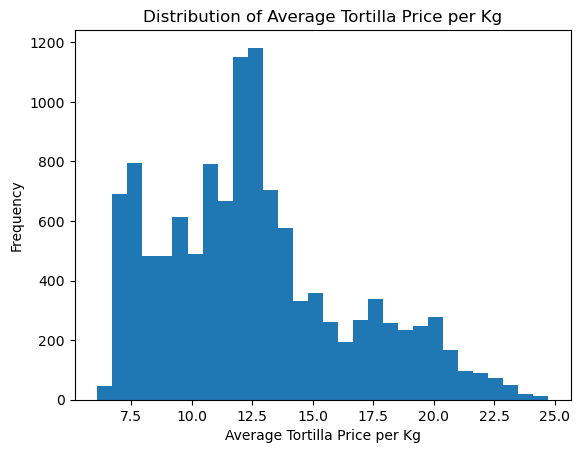

In [13]:

plt.figure()
plt.hist(parent["avg_tort_ppk"].dropna(), bins=30)
plt.xlabel("Average Tortilla Price per Kg")
plt.ylabel("Frequency")
plt.title("Distribution of Average Tortilla Price per Kg")
plt.show()

In [14]:
parent = parent[(parent["Year"] >= 2011) & (parent["Year"] <= 2017)].copy()

In [15]:
parent = parent.dropna().copy()

In [16]:
parent["totalpop_log"] = parent["total_pop"].apply(np.log)

In [17]:
train = parent[parent["Year"] <= 2015]
test  = parent[parent["Year"] > 2015]

In [23]:
features_A = [
    "totalpop_log",
    "Price_MXN_per_Ton",
    "Year",
    "Month"
]

features_B = features_A + [
    "illegal_tap_count",
    "fuel_pipeline"
]

In [24]:
y_train = train["avg_tort_ppk"]
y_test  = test["avg_tort_ppk"]

X_train_A = train[features_A]
X_test_A  = test[features_A]

X_train_B = train[features_B]
X_test_B  = test[features_B]

In [25]:
model_A = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model_B = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

model_A.fit(X_train_A, y_train)
model_B.fit(X_train_B, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [26]:
preds_A = model_A.predict(X_test_A)
preds_B = model_B.predict(X_test_B)

rmse_A = np.sqrt(mean_squared_error(y_test, preds_A))
rmse_B = np.sqrt(mean_squared_error(y_test, preds_B))

print("Baseline RMSE:", rmse_A)
print("With taps RMSE:", rmse_B)

print("Percent improvement:",
      100 * (rmse_A - rmse_B) / rmse_A)

Baseline RMSE: 1.1927211834275453
With taps RMSE: 1.1225311635130946
Percent improvement: 5.884864031067542


In [27]:
pd.Series(
    model_B.feature_importances_,
    index=features_B
).sort_values(ascending=False)

Year                 0.710352
totalpop_log         0.116372
illegal_tap_count    0.090655
fuel_pipeline        0.050612
Month                0.020914
Price_MXN_per_Ton    0.011096
dtype: float32